# Rendering

A differentiable renderer is necessary to faciliate learning from comparisons between depth images.

In [1]:
import math
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import torch
import torchvision


def dist(p1, p2):
    return (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2
    

def render_point(point, img, r=1.0):
    x_range = [max(0, math.floor(point[0] - r)), min(img.shape[0], math.ceil(point[0] + r))]
    for i in range(x_range[0], x_range[1]):
        y_range = [max(0, math.floor(point[1] - r)), min(img.shape[0], math.ceil(point[1] + r))]
        for j in range(y_range[0], y_range[1]):
            d_point = dist(torch.tensor([i, j], dtype=torch.float32), point)
            if d_point**2 < r**2:
                phi = (1 - (d_point / r)**2)**2
                depth = (1 - point[2]) * phi
                if depth > img[j, i]:
                    img[j, i] = depth

Rendering time: 438.9774419996684 ms


<IPython.core.display.Javascript object>


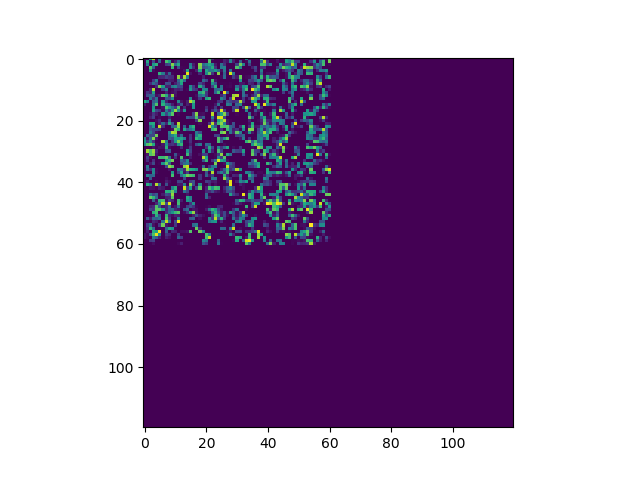

In [5]:
num_points = 1000

img_raw = torch.zeros(120, 120)
points = torch.rand(num_points, 3)
points[:, :2] *= 60.0

start = timer()
for p in range(num_points):
    render_point(points[p], img_raw)
end = timer()
print("Rendering time: {} ms".format((end - start) * 1000.0))
    
to_img = torchvision.transforms.ToPILImage()
img = to_img(img_raw)

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(img)

## CUDA Implementation

The above implementation is far too inefficient to be used in practice. We can greatly increase the performance by implementing this in CUDA.

Rendering time: 0.6737180083291605 ms


<IPython.core.display.Javascript object>


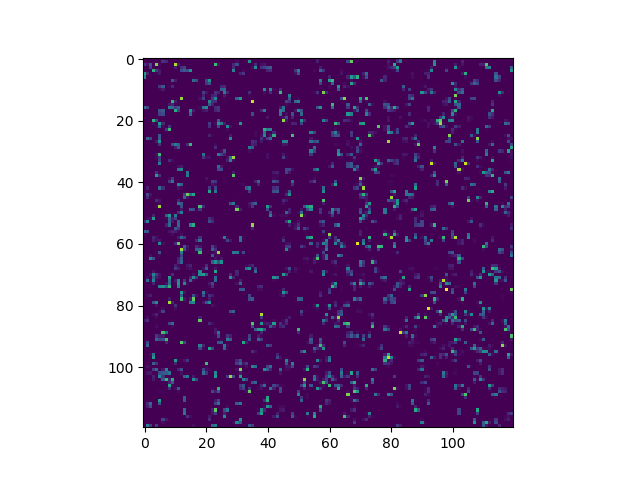

In [4]:
import sys

if ".." not in sys.path:
    sys.path.append("..")
    
from model import Renderer


height = 120
width = 120
radius = 1.0
renderer = Renderer.Renderer(height, width, radius)

renderer.cuda()

start = timer()
depth_img = renderer(points.unsqueeze(0).to(torch.device('cuda')))
end = timer()
print("Rendering time: {} ms".format((end - start) * 1000.0))

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(depth_img[0].cpu())

[1.0000000e+00 9.9980001e-01 9.9920016e-01 9.9820081e-01 9.9680256e-01
 9.9500625e-01 9.9281296e-01 9.9022401e-01 9.8724096e-01 9.8386561e-01
 9.8010000e-01 9.7594641e-01 9.7140736e-01 9.6648561e-01 9.6118416e-01
 9.5550625e-01 9.4945536e-01 9.4303521e-01 9.3624976e-01 9.2910321e-01
 9.2160000e-01 9.1374481e-01 9.0554256e-01 8.9699841e-01 8.8811776e-01
 8.7890625e-01 8.6936976e-01 8.5951441e-01 8.4934656e-01 8.3887281e-01
 8.2810000e-01 8.1703521e-01 8.0568576e-01 7.9405921e-01 7.8216336e-01
 7.7000625e-01 7.5759616e-01 7.4494161e-01 7.3205136e-01 7.1893441e-01
 7.0560000e-01 6.9205761e-01 6.7831696e-01 6.6438801e-01 6.5028096e-01
 6.3600625e-01 6.2157456e-01 6.0699681e-01 5.9228416e-01 5.7744801e-01
 5.6250000e-01 5.4745201e-01 5.3231616e-01 5.1710481e-01 5.0183056e-01
 4.8650625e-01 4.7114496e-01 4.5576001e-01 4.4036496e-01 4.2497361e-01
 4.0960000e-01 3.9425841e-01 3.7896336e-01 3.6372961e-01 3.4857216e-01
 3.3350625e-01 3.1854736e-01 3.0371121e-01 2.8901376e-01 2.7447121e-01
 2.601

<IPython.core.display.Javascript object>


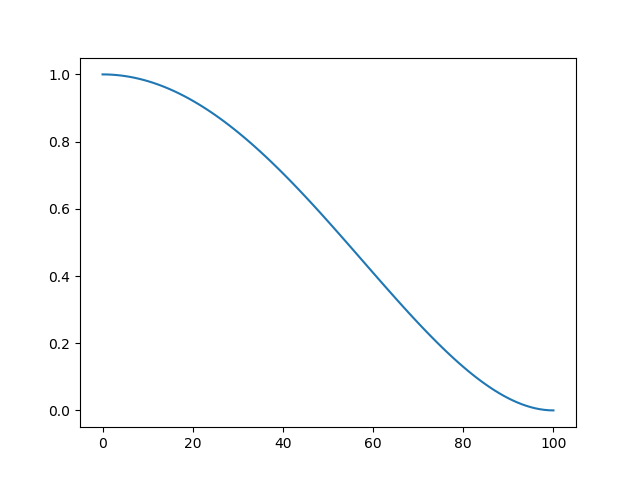

In [19]:
import numpy as np

r = 1.0
x = np.arange(0, 1.01, 0.01)
phi = (1 - (x / r)**2)**2
print(phi)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(phi)